In [1]:
import torch
print(torch.cuda.is_available())

True


# Import Library

In [3]:
# Import libraries
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import emoji
import string
import nltk
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

 # Load Dataset

In [6]:
# Load dataset
file_name = "tripadvisor_hotel_reviews.csv"

# Read the CSV file
combined_df = pd.read_csv(file_name)

# Display the first few rows of the dataset
print(combined_df.head())

                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5


# Data Preprocessing

In [8]:
# unduh stopwords dari NLTK
nltk.download('stopwords')

# Text cleaning function
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

# Apply cleaning and remove missing data
combined_df['cleaned_review'] = combined_df['Review'].apply(clean_text)
combined_df.dropna(subset=['cleaned_review', 'Rating'], inplace=True)

print("Data cleaning completed!")
print(combined_df.head())


[nltk_data] Downloading package stopwords to C:\Users\Muhammad
[nltk_data]     Giat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data cleaning completed!
                                              Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

   sentiment_encoded                                     cleaned_review  
0                  1  nice hotel expensive parking got good deal sta...  
1                  0  ok nothing special charge diamond member hilto...  
2                  1  nice rooms experience hotel monaco seattle goo...  
3                  1  unique great stay wonderful time hotel monaco ...  
4                  1  great stay great stay went seahawk game awesom...  


In [22]:
# Encode sentiment labels based on rating
combined_df['sentiment_encoded'] = combined_df['Rating'].map(lambda x: 1 if x >= 3 else 0)
combined_df['sentiment_label'] = combined_df['sentiment_encoded'].map({0: 'Negative', 1: 'Positive'})

# Split data into train, validation, and test sets
X = combined_df['cleaned_review'].values
y = combined_df['sentiment_encoded'].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

# Display the sentiment labels
train_labels = combined_df.loc[combined_df['cleaned_review'].isin(X_train), 'sentiment_label']
val_labels = combined_df.loc[combined_df['cleaned_review'].isin(X_val), 'sentiment_label']
test_labels = combined_df.loc[combined_df['cleaned_review'].isin(X_test), 'sentiment_label']

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 14343
Validation samples: 4918
Test samples: 1230


In [26]:
# Display the distribution of sentiment labels in the training set
print("Data pelatihan:")
print(pd.DataFrame({'cleaned_review': X_train, 'sentiment_encoded': y_train, 'sentiment_label': combined_df.loc[combined_df['cleaned_review'].isin(X_train), 'sentiment_label'].values}).head())

# Display the distribution of sentiment labels in the validation set
print("Data validasi:")
print(pd.DataFrame({'cleaned_review': X_val, 'sentiment_encoded': y_val, 'sentiment_label': combined_df.loc[combined_df['cleaned_review'].isin(X_val), 'sentiment_label'].values}).head())

# Display the distribution of sentiment labels in the test set
print("Data pengujian:")
print(pd.DataFrame({'cleaned_review': X_test, 'sentiment_encoded': y_test, 'sentiment_label': combined_df.loc[combined_df['cleaned_review'].isin(X_test), 'sentiment_label'].values}).head())

Data pelatihan:
                                      cleaned_review  sentiment_encoded  \
0  beautiful hotel beautiful hotel night sept big...                  1   
1  disappointed booked hotel work retreat partly ...                  0   
2  great hotel perfect location got nights barcel...                  1   
3  favourite pick places stayed europe partner we...                  1   
4  fantastic hotet returned night stay hotel fant...                  1   

  sentiment_label  
0        Positive  
1        Negative  
2        Positive  
3        Positive  
4        Positive  
Data validasi:
                                      cleaned_review  sentiment_encoded  \
0  come architecture nt stay architecture interes...                  0   
1  cheap lounge hotel located min placa catalunya...                  0   
2  like property needs work stayed hotel years ag...                  1   
3  average private beach surprisingly uncrowded c...                  1   
4  room primping room s

# Tokenization and Padding

In [27]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets and dataloaders
train_dataset = SentimentDataset(X_train, y_train, tokenizer)
val_dataset = SentimentDataset(X_val, y_val, tokenizer)
test_dataset = SentimentDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Model Building

In [29]:
# Load pre-trained BERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Model Training

In [30]:
# Training loop
epochs = 3
train_losses = []
val_losses = []   
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        predictions = torch.argmax(logits, dim=-1)
        correct_train_predictions += (predictions == labels).sum().item()
        total_train_samples += labels.size(0)

    train_losses.append(total_train_loss / len(train_loader))
    train_accuracies.append(correct_train_predictions / total_train_samples)

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_val_loss += loss.item()
            predictions = torch.argmax(logits, dim=-1)
            correct_val_predictions += (predictions == labels).sum().item()
            total_val_samples += labels.size(0)

    val_losses.append(total_val_loss / len(val_loader))
    val_accuracies.append(correct_val_predictions / total_val_samples)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, "
          f"Train Accuracy: {train_accuracies[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

100%|██████████| 897/897 [06:49<00:00,  2.19it/s]


Epoch 1/3, Train Loss: 0.2072, Train Accuracy: 0.9147, Val Loss: 0.1605, Val Accuracy: 0.9345


100%|██████████| 897/897 [06:54<00:00,  2.17it/s]


Epoch 2/3, Train Loss: 0.1260, Train Accuracy: 0.9501, Val Loss: 0.1626, Val Accuracy: 0.9410


100%|██████████| 897/897 [07:26<00:00,  2.01it/s]


Epoch 3/3, Train Loss: 0.0782, Train Accuracy: 0.9705, Val Loss: 0.1862, Val Accuracy: 0.9394


# Model Evaluation

In [31]:
# Evaluate the model on the test set
model.eval()
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=-1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

test_accuracy = correct_predictions / total_predictions
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9358


In [32]:
# Put model in evaluation mode
model.eval()

# Collect all predictions and labels
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=["Negative", "Positive"]))

Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.77      0.80       771
    Positive       0.96      0.97      0.96      4147

    accuracy                           0.94      4918
   macro avg       0.90      0.87      0.88      4918
weighted avg       0.94      0.94      0.94      4918



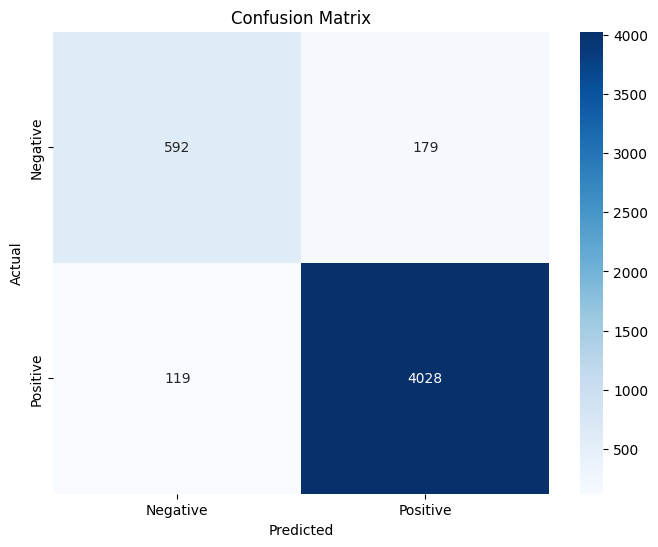

In [33]:
# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot Performances

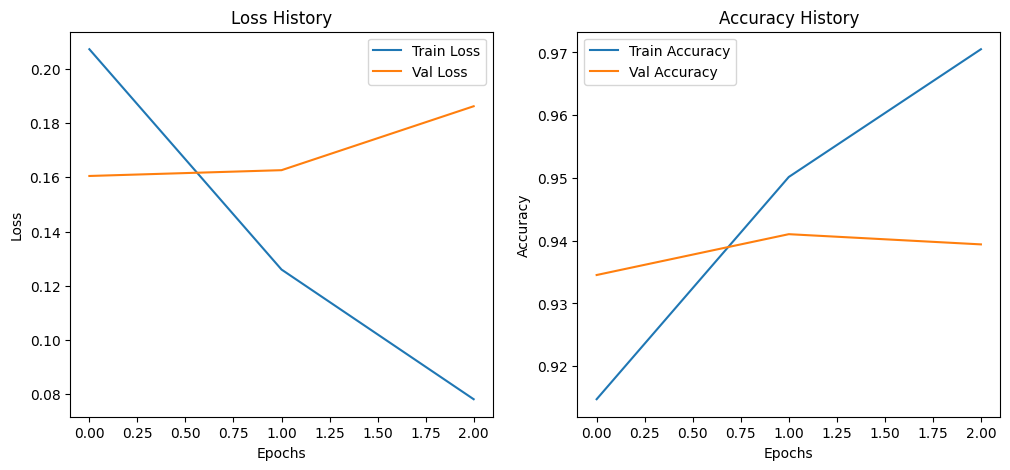

In [34]:
# Plot training history
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss History")

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy History")

plt.show()

# Testing & Prediction

In [35]:
# Predict on New Data
def predict_sentiment(text):
    model.eval()
    inputs = tokenizer(text, truncation=True, padding=True, max_length=128, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=-1).item()
    return ["Negative", "Positive"][prediction]

# Test the model with new reviews
test_texts = [
    "The hotel was great! I had an amazing experience.",
    "The hotel was terrible. I will never stay there again!",
]

for text in test_texts:
    sentiment = predict_sentiment(text)
    print(f"Review: {text}\nPredicted Sentiment: {sentiment}\n")


Review: The hotel was great! I had an amazing experience.
Predicted Sentiment: Positive

Review: The hotel was terrible. I will never stay there again!
Predicted Sentiment: Negative

